# Completing mid-ocean ridge faults detection using semi-supervised learning

![](content/image_faults.jpg)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
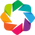

In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import holoviews as hv
hv.extension('bokeh')
from skimage.morphology import binary_dilation
from utils import dataSplit
from model import unet, mean_iou
from ipywidgets import interact, widgets

## Given dataset

In [2]:
bat = scipy.io.loadmat("Bathy.mat")['IMG2']
fault = scipy.io.loadmat("Fault_Bool.mat")['Fault_Bool']
fault = binary_dilation(fault, selem=np.ones((10,10)))

In [3]:
bat_mean = np.nanmean(bat)
bat_std = np.nanstd(bat)
    
x, y = dataSplit(bat, 256), dataSplit(fault, 256) 
x_all, y_all = np.copy(x), np.copy(y)

idx = list(map(lambda x: not np.all(x), np.isnan(x).sum(axis=(1,2,3)) > (256**2) / 2))
x, y = x[idx], y[idx]

fail_threshold = 0.05
y_mean = y.mean(axis=(1, 2, 3))
x, y = x[y_mean>fail_threshold], y[y_mean>fail_threshold]

x_mean = np.nanmean(x, axis=(1, 2))[:, None, None, :]
x_std = np.nanstd(x, axis=(1, 2))[:, None, None, :]
x = (x - x_mean)/x_std
x[np.isnan(x)] = 0

x_all_mean = np.nanmean(x_all, axis=(1, 2))[:, None, None, :]
x_all_std = np.nanstd(x_all, axis=(1, 2))[:, None, None, :]
x_all = (x_all - x_all_mean)/x_all_std
x_all[np.isnan(x_all)] = 0

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


In [4]:
@interact(index=widgets.IntSlider(min=0, max=len(x), step=1, value=2))
def display(index):
    fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
    cm1 = ax1.pcolormesh(np.squeeze(x[index]), vmin=-2, vmax=2)
    fig.colorbar(cm1, ax=ax1)
    ax1.set_title("Sea levels")

    cm2 = ax2.pcolormesh(np.squeeze(y[index]), vmin=0, vmax=1)
    fig.colorbar(cm2, ax=ax2)
    ax2.set_title("Labeled fails")

    ax3.hist(bat.ravel())
    ax3.set_title("Sea levels distribution")

    plt.show()

interactive(children=(IntSlider(value=2, description='index', max=43), Output()), _dom_classes=('widget-intera…

## Training the model

![](content/u-net-architecture.png)

In [5]:
input_shape = (256, 256, 1)

model = unet(input_shape=input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.fit(x, y, epochs=30, batch_size=4, validation_split=0.2, verbose=0)
y_pred = model.predict(x_all)

## Evaluating predictions

In [6]:
y_pred_all = np.squeeze(y_pred.reshape((8, 15, 256, 256, 1)))

y_pred_all = np.block([[y_pred_all[i, j] for i in range(8)] for j in range(15)])

In [7]:
y_all = np.squeeze(y_all.reshape((8, 15, 256, 256, 1)))

y_all = np.block([[y_all[i, j] for i in range(8)] for j in range(15)])

In [8]:
x_all = np.squeeze(x_all.reshape((8, 15, 256, 256, 1)))

x_all = np.block([[x_all[i, j] for i in range(8)] for j in range(15)])

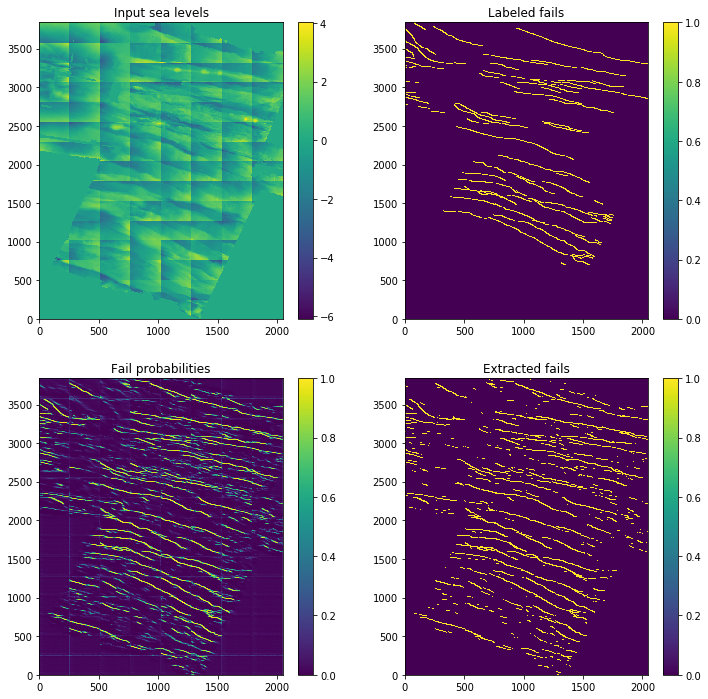

In [9]:
fig, [[ax0, ax1], [ax2, ax3]] = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

cm0 = ax0.pcolormesh(np.squeeze(x_all))
fig.colorbar(cm0, ax=ax0)
ax0.set_title("Input sea levels")

cm1 = ax1.pcolormesh(np.squeeze(y_all), vmin=0, vmax=1)
fig.colorbar(cm1, ax=ax1)
ax1.set_title("Labeled fails")

cm2 = ax2.pcolormesh(np.squeeze(y_pred_all), vmin=0, vmax=1)
fig.colorbar(cm2, ax=ax2)
ax2.set_title("Fail probabilities")

cm3 = ax3.pcolormesh(np.squeeze(y_pred_all >0.5), vmin=0, vmax=1)
fig.colorbar(cm3, ax=ax3)
ax3.set_title("Extracted fails")

plt.show()